# Training the Model

## 1. Imports

In [1]:
import matplotlib.pyplot as plt
import multiprocessing as mp
import nibabel as nib
import numpy as np
import os
import pandas as pd
import tempfile
from sklearn import metrics
import time
from time import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from monai.networks.nets import AHNet
from tqdm import tqdm
import monai
from monai.config import print_config
from monai.data import Dataset, DataLoader, CacheDataset
from monai.transforms import (
    Activations,
    AsDiscrete,
    Compose,
    EnsureChannelFirstd,
    EnsureTyped,
    LoadImaged,
    MapTransform,
    Orientationd,
    RandRicianNoised,
    RandRotated,
    RandFlipd,
    Resized,
    Rotate90d,
    ScaleIntensityd,
    DeleteItemsd,
    NormalizeIntensityd
)


### 1.1 Set Environment Variables for GPU

In [8]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1,2,3"

### 1.2 Get Stored Dictionaries from CreateDataset

In [3]:
%store -r dictionary_train
%store -r dictionary_valid
%store -r dictionary_test

## 2. MONAI Dataloader

### 2.1 Data Transforms

In [4]:
#To turn 4D images to 3D (from Ashley's classifier)
class MakeSingleVolumed(MapTransform):
    def __call__(self, data):
        for key in self.keys:
            num_volumes = data[key].shape[0]
            data["NumVolumes"] = num_volumes
            
            if num_volumes != 1:
                middle_volume = num_volumes // 2
                new_data = np.empty((1,128,128,64))
                new_data[0,:,:,:] = data[key][middle_volume,:,:,:]
                # fill last slice with the value of num_volumes 
                new_data[0,:,:,-1] = np.zeros((data[key].shape[1],data[key].shape[2])) + num_volumes
                data[key] = torch.from_numpy(new_data)
            else:
                new_data = np.empty((1,128,128,64))
                new_data[0,:,:,:] = data[key][0,:,:,:]
                # fill last slice with the value of num_volumes 
                new_data[0,:,:,-1] = np.zeros((data[key].shape[1],data[key].shape[2])) + num_volumes
                data[key] = torch.from_numpy(new_data)
                
        return data

#This uses the mask to scale the intensity of the image (not being used rn)
class ScaleImaged(MapTransform):
    def __call__(self, data):
            data[self.keys[0]] *= (0.4+data[self.keys[1]])

            return data


#### 2.1.1 Set Training and Validation Transforms

In [5]:
train_transforms = Compose(
    [
        LoadImaged(keys=["t1", "t1c", "t2", "flair"], reader=monai.data.ITKReader, image_only=True),
        EnsureChannelFirstd(keys=["t1", "t1c", "t2", "flair"]),
        Orientationd(keys=["t1", "t1c", "t2", "flair"], axcodes="RAS"),        
        EnsureTyped(keys=["t1", "t1c", "t2", "flair"]),
        Resized(keys=["t1", "t1c", "t2", "flair"], spatial_size=(128,128,64)),
        MakeSingleVolumed(keys=["t1", "t1c", "t2", "flair"]),
        Rotate90d(keys=["t1", "t1c", "t2", "flair"]),
        RandFlipd(keys=["t1", "t1c", "t2", "flair"], prob=0.5, spatial_axis=1),
        RandRotated(keys=["t1", "t1c", "t2", "flair"], prob=0.6, range_z=0.3),
        ScaleIntensityd(keys=["t1", "t1c", "t2", "flair"]),
        NormalizeIntensityd(keys=["t1", "t1c", "t2", "flair"])
    ]
)

val_transforms = Compose(
    [
        LoadImaged(keys=["t1", "t1c", "t2", "flair"], reader=monai.data.ITKReader, image_only=True),
        EnsureChannelFirstd(keys=["t1", "t1c", "t2", "flair"]),
        Orientationd(keys=["t1", "t1c", "t2", "flair"], axcodes="RAS"),        
        EnsureTyped(keys=["t1", "t1c", "t2", "flair"]),
        Resized(keys=["t1", "t1c", "t2", "flair"], spatial_size=(128,128,64)),
        MakeSingleVolumed(keys=["t1", "t1c", "t2", "flair"]),
        Rotate90d(keys=["t1", "t1c", "t2", "flair"]),
        ScaleIntensityd(keys=["t1", "t1c", "t2", "flair"]),
        NormalizeIntensityd(keys=["t1", "t1c", "t2", "flair"])
    ]
)

#### 2.1.2 Test the Transforms


In [6]:
val_files = dictionary_train[:10]

check_ds = Dataset(data=val_files, transform=train_transforms)
check_DataLoader = DataLoader(check_ds, batch_size=1, shuffle=False)

It has been 5.737281560897827 seconds since the loop started


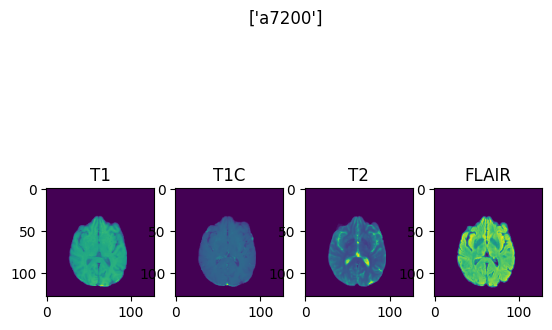

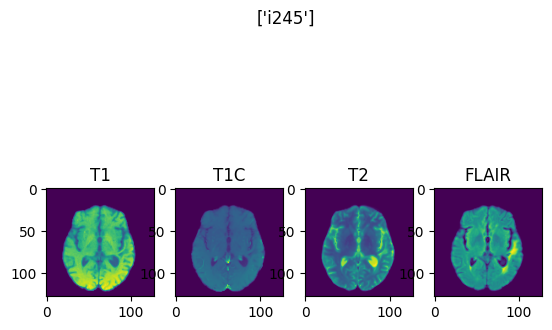

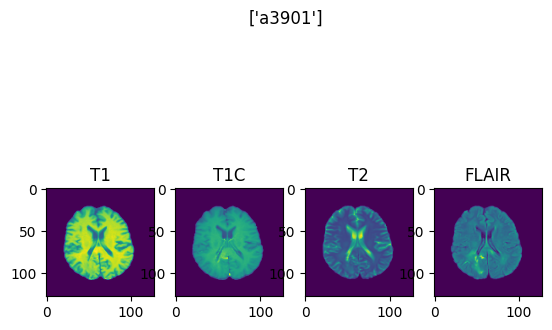

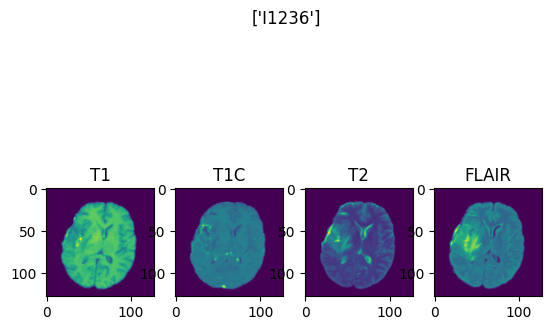

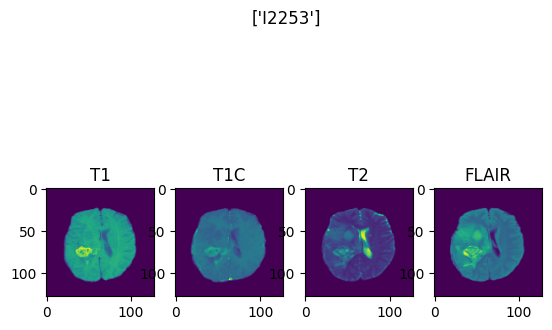

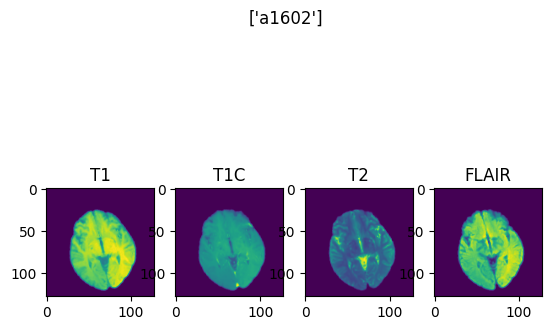

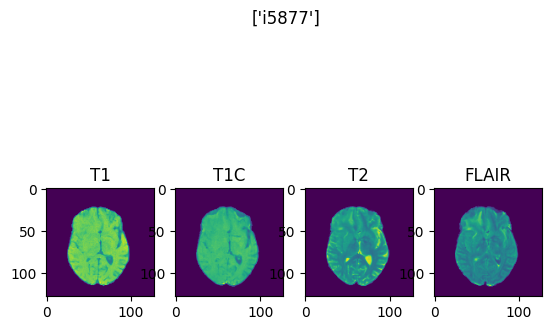

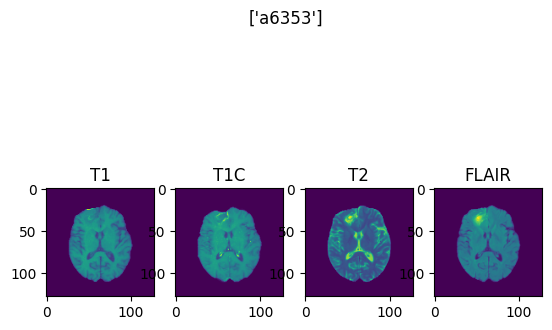

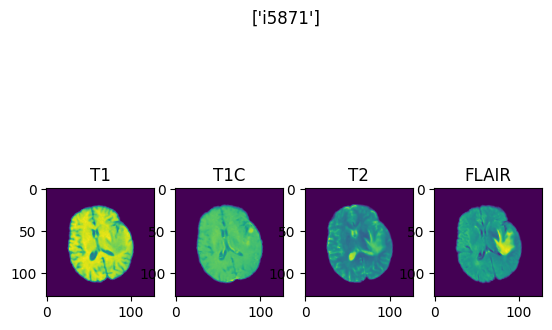

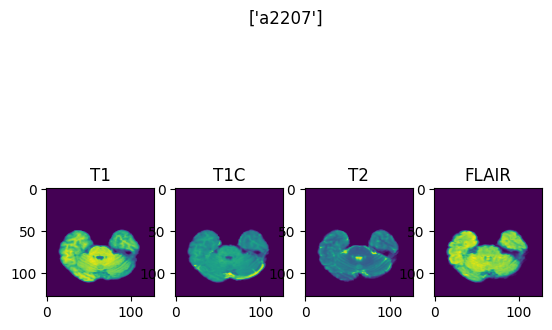

In [9]:
program_starts = time()
step = 1350
slice_index = 32
for item in check_DataLoader:
    image_datas = item["t1"][0, 0, :, :, slice_index], item["t1c"][0, 0, :, :, slice_index], item["t2"][0, 0, :, :, slice_index], item["flair"][0, 0, :, :, slice_index]
    title = item["id"]
    
    f, axarr = plt.subplots(1, 4)
    
    axarr[0].imshow(image_datas[0])
    axarr[0].set_title("T1")
    axarr[1].imshow(image_datas[1])
    axarr[1].set_title("T1C")
    axarr[2].imshow(image_datas[2])
    axarr[2].set_title("T2")
    axarr[3].imshow(image_datas[3])
    axarr[3].set_title("FLAIR")
    f.suptitle(title)
    
    step += 1
now = time()
print("It has been {0} seconds since the loop started".format(now - program_starts))

## 2.2 Create Train/Valid/Test DataLoaders

In [11]:
print(os.cpu_count())

train_ds = CacheDataset(data=dictionary_train, transform=train_transforms, cache_num=1024, num_workers=os.cpu_count())
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=os.cpu_count(), drop_last=True)

valid_ds = CacheDataset(data=dictionary_valid, transform=val_transforms, cache_num=1024, num_workers=os.cpu_count())
valid_loader = DataLoader(valid_ds, batch_size=4, shuffle=False, num_workers=os.cpu_count())

test_ds = CacheDataset(data=dictionary_test, transform=val_transforms, cache_num=1024, num_workers=os.cpu_count())
test_loader = DataLoader(test_ds, batch_size=4, shuffle=False, num_workers=os.cpu_count())

20


Loading dataset: 100%|██████████████████████████| 73/73 [00:18<00:00,  3.91it/s]


## 3. Custom AH-net


### 3.0 AH-Net for Binary Classification

In [14]:
class AHNetForBinaryClassification(nn.Module):
    def __init__(self, dropout_prob=0):
        super(AHNetForBinaryClassification, self).__init__()
        # Initialize the AHNet
        self.ahnet = AHNet(spatial_dims=3, in_channels=4, out_channels=16, pretrained=True)


        self.conv1 = nn.Conv3d(16, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm3d(32)
        self.pool1 = nn.AdaptiveAvgPool3d(output_size=(64, 64, 32))
        
        self.conv2 = nn.Conv3d(32, 64, kernel_size=5)
        self.bn2 = nn.BatchNorm3d(64)
        self.pool2 = nn.AdaptiveAvgPool3d(output_size=(6, 6, 6))

        
        # Fully connected layers
        self.fc1 = nn.Linear(64*6*6*6, 128) 
        self.bn_fc1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 2)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        # Pass input through AHNet
        x = self.ahnet(x)
        
        x = F.relu(self.conv1(x))
        x = self.pool1(x)

        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

### 3.1 Model and Device Setup


In [38]:
# Use GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = monai.networks.nets.Densenet121(
    spatial_dims=3,
    in_channels=4,
    out_channels=2
)

# If multiple GPUs are available, run in parallel
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)
model.to(device)

#Create weights based on uneven class distribution
count_neg = 450
count_pos = 325
total = count_neg + count_pos
weight_neg = (1 / count_neg) * (total / 2.0)
weight_pos = (1 / count_pos) * (total / 2.0)
class_weights = torch.FloatTensor([weight_neg, weight_pos]).cuda()

# Use the weights in the loss function
loss_function = nn.CrossEntropyLoss(weight=class_weights)

optimizer = torch.optim.Adam(model.parameters(), lr=14e-6, weight_decay=1e-5)
#scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

cuda
Let's use 3 GPUs!


#### 3.1.1 Helper Function to Visualize Training Curves

In [39]:
def plot_curves(train_loss, val_loss, train_acc, val_acc):
    plt.figure("train", (12, 12))

    plt.subplot(2, 1, 1)
    plt.title("Epoch Average Loss")
    x = [i + 1 for i in range(len(train_loss))]
    y = train_loss
    plt.xlabel("epoch")
    plt.plot(x, y)
    x = [i + 1 for i in range(len(val_loss))]
    y = val_loss
    plt.plot(x, y)
    plt.legend(('Training', 'Validation'))


    plt.subplot(2, 1, 2)
    plt.title("Accuracy")
    x = [(i + 1) for i in range(len(train_acc))]
    y = train_acc
    plt.xlabel("epoch")
    plt.plot(x, y)
    x = [(i + 1) for i in range(len(val_acc))]
    y = val_acc
    plt.plot(x, y)
    plt.legend(('Training', 'Validation'))
    
    plt.show()

### 3.2 Training

----------
epoch 1/20


Epoch : 100%|████| 151/151 [00:54<00:00,  2.77it/s, Overall Training Loss=0.574]


saved new best metric model
current epoch: 1 current avg accuracy: 0.4553 best accuracy: 0.4553 at epoch 1
Num guessed positive: 
284
train accuracy: 0.6954 validation accuracy: 0.4553 train loss: 0.5762 validation loss 0.7777
----------
epoch 2/20


Epoch : 100%|████| 151/151 [00:55<00:00,  2.74it/s, Overall Training Loss=0.685]


saved new best metric model
current epoch: 2 current avg accuracy: 0.5528 best accuracy: 0.5528 at epoch 2
Num guessed positive: 
280
train accuracy: 0.7632 validation accuracy: 0.5528 train loss: 0.4941 validation loss 0.8673
----------
epoch 3/20


Epoch : 100%|████| 151/151 [00:56<00:00,  2.68it/s, Overall Training Loss=0.546]


current epoch: 3 current avg accuracy: 0.5041 best accuracy: 0.5528 at epoch 2
Num guessed positive: 
280
train accuracy: 0.7517 validation accuracy: 0.5041 train loss: 0.4838 validation loss 0.9773
----------
epoch 4/20


Epoch : 100%|████| 151/151 [00:56<00:00,  2.69it/s, Overall Training Loss=0.726]


current epoch: 4 current avg accuracy: 0.5122 best accuracy: 0.5528 at epoch 2
Num guessed positive: 
276
train accuracy: 0.7434 validation accuracy: 0.5122 train loss: 0.4998 validation loss 0.8950
----------
epoch 5/20


Epoch : 100%|█████| 151/151 [00:55<00:00,  2.72it/s, Overall Training Loss=0.61]


current epoch: 5 current avg accuracy: 0.4715 best accuracy: 0.5528 at epoch 2
Num guessed positive: 
276
train accuracy: 0.7086 validation accuracy: 0.4715 train loss: 0.5331 validation loss 0.9257


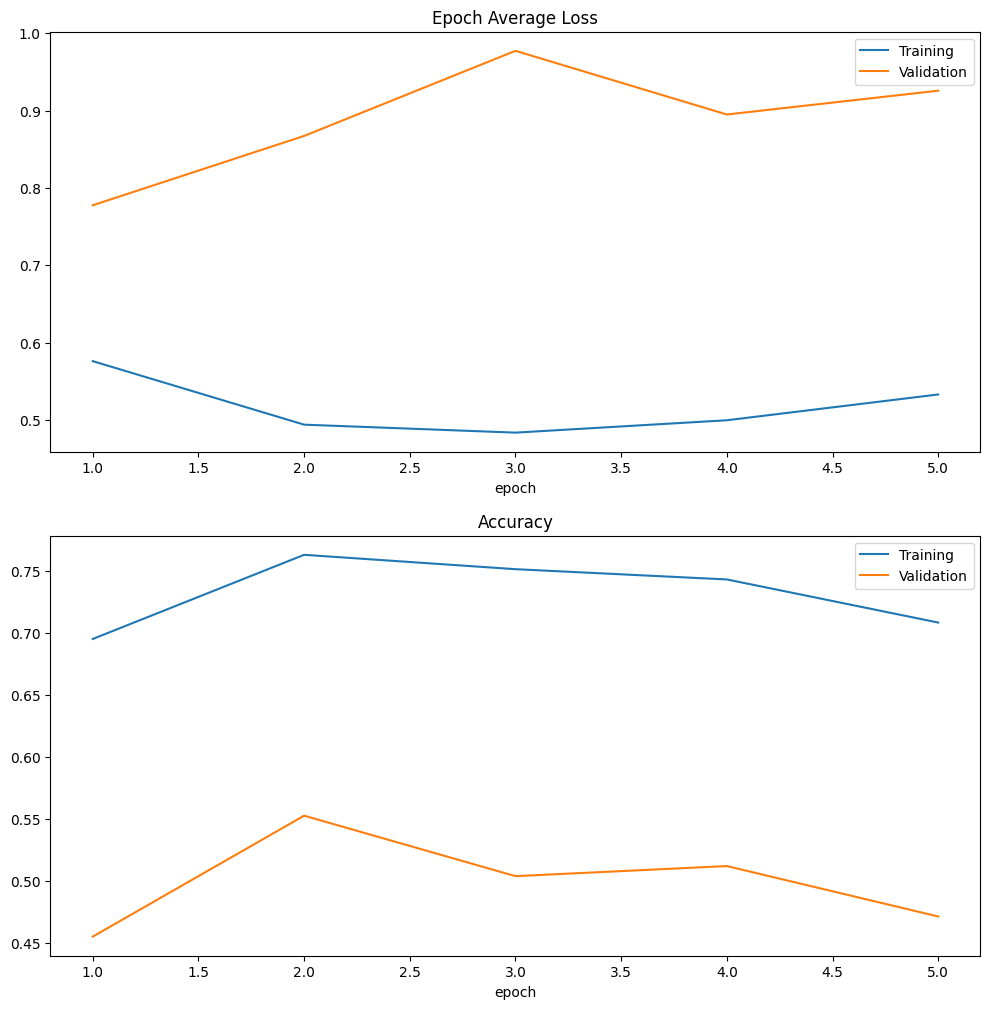

----------
epoch 6/20


Epoch :   0%|                                           | 0/151 [00:00<?, ?it/s]

In [ ]:
val_interval = 1    # validate at every n epochs
graph_interval = 5    # plot training graphs every n epochs

best_metric = -1    # default value
best_metric_epoch = -1    # default value

# arrays to keep track of loss and accuracy for plotting curves
train_loss = []
val_loss = []
train_acc = []
val_acc = []


train_acc = []
val_acc = []

num_epochs = 20

torch.cuda.empty_cache()
optimizer = torch.optim.Adam(model.parameters(), lr=8e-6, weight_decay=1e-5)


for epoch in range(num_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{num_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    
    num_correct = 0.0
    metric_count = 0
    num_guessed_positive = 0
    
    # TRAINING
    # using tqdm will show progress bar for each epoch
    with tqdm(train_loader, desc=("Epoch ")) as pbar:
        # iterate through train_loader batches
        for i, batch_data in enumerate(pbar):
            step += 1
            image = torch.cat((batch_data["t1"].to(device, dtype=torch.float), batch_data["t1c"].to(device, dtype=torch.float), batch_data["t2"].to(device, dtype=torch.float), batch_data["flair"].to(device, dtype=torch.float)), dim = 1) 
            labels = torch.zeros(len(batch_data["t1"]), 2).to(device)
            
            for i in range(len(batch_data["t1"])):
                labels[i] = torch.from_numpy(np.asarray([batch_data["MGMTn"][i], batch_data["MGMTp"][i]]).astype('int64'))
            
            optimizer.zero_grad()
            output = model(image)

            #l1_lambda = 25e-7  # Regularization strength
            #l1_norm = sum(p.abs().sum() for p in model.parameters())
            
            loss = loss_function(output, labels) #+ (l1_lambda * l1_norm)
            loss.backward()
                           
            optimizer.step()
            
            # values for calculating accuracy
            num_guessed_positive += (torch.sigmoid(output[:, 1]) > torch.sigmoid(output[:, 0])).sum().item()
            value = torch.eq((torch.sigmoid(output[:, 1]) > torch.sigmoid(output[:, 0])).float(), labels[:, 1])
            metric_count += len(value)
            num_correct += value.sum().item()    
            
            # epoch loss
            epoch_loss += loss.item()
                                                                                      
            epoch_len = len(train_ds) // train_loader.batch_size
            
            # update progress bar to display loss
            pbar.set_postfix({'Overall Training Loss': loss.item()})
            
        # append loss and accuracy
        epoch_loss /= step
        train_loss.append(epoch_loss)
        metric = num_correct / metric_count
        train_acc.append(metric)
        #scheduler.step()
    
        # VALIDATION
        if (epoch + 1) % val_interval == 0:
            model.eval()
            with torch.no_grad():

                y_pred = torch.tensor([], dtype=torch.float32, device=device)
                y = torch.tensor([], dtype=torch.long, device=device)
                                                                
                
                # iterate through valid_loader batches
                for i, val_data in enumerate(valid_loader):
                    val_image = torch.cat((val_data["t1"].to(device, dtype=torch.float), val_data["t1c"].to(device, dtype=torch.float), val_data["t2"].to(device, dtype=torch.float), val_data["flair"].to(device, dtype=torch.float)), dim=1)
                    val_labels = torch.zeros(len(val_data["t1"]), 2).to(device)
            
                    for i in range(len(val_data["t1"])):
                        val_labels[i] = torch.from_numpy(np.asarray([val_data["MGMTn"][i], val_data["MGMTp"][i]]).astype('int64'))
                        
                    output = model(val_image)
                    y_pred = torch.cat([y_pred, output], dim=0)
                    y = torch.cat([y, val_labels], dim=0)
                    
                # calculate and append loss
                loss = loss_function(y_pred, y)
                val_loss.append(loss.item())
                
                # calculate and append accuracy
                acc_value = torch.eq((torch.sigmoid(y_pred[:, 1]) > torch.sigmoid(y_pred[:, 0])).float(), y[:, 1])
                acc_metric = (acc_value.sum().item()) / len(acc_value)
                val_acc.append(acc_metric)


                # update best metric
                if acc_metric > best_metric:
                    best_metric = acc_metric
                    best_metric_epoch = epoch + 1
                    torch.save({
                        'epoch': epoch,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'loss': loss,
                        'train_loss_arr': train_loss,
                        'val_loss_arr': val_loss,
                        'train_acc_arr': train_acc,
                        'val_acc_arr': val_acc,
                        'val_acc': val_acc,
                        'train_acc': train_acc,
                        }, "best_metric_ahnet.pth")
                    print("saved new best metric model")
                print(
                    "current epoch: {} current avg accuracy: {:.4f} best accuracy: {:.4f} at epoch {}".format(
                        epoch + 1, acc_metric, best_metric, best_metric_epoch
                    )
                )
                print("Num guessed positive: ")
                print(num_guessed_positive)
                print(
                    "train accuracy: {:.4f} validation accuracy: {:.4f} train loss: {:.4f} validation loss {:.4f}".format(
                        train_acc[-1], acc_metric, train_loss[-1],loss.item()
                    )
                )
                
        # display train/validation curves
        if (epoch + 1) % graph_interval == 0:
            plot_curves(train_loss, val_loss, train_acc, val_acc)
        
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")

## 4. Evaluating Results

### 4.1 Evaluating the Model on the Test Dataset

In [ ]:
torch.cuda.empty_cache()

saved_dict = torch.load("best_metric_ahnet.pth")
model.load_state_dict(saved_dict['model_state_dict'])
model.eval()

y_pred = torch.tensor([]).to(device)
y = torch.tensor([]).to(device)
                                                                
                
# iterate through test_loader batches
for test_data in test_loader:
    with torch.no_grad():
        test_image = torch.cat((test_data["t1"].to(device, dtype=torch.float), test_data["t1c"].to(device, dtype=torch.float), test_data["t2"].to(device, dtype=torch.float), test_data["flair"].to(device, dtype=torch.float)), dim=1)
        test_labels = torch.zeros(len(test_data["t1"]), 2).to(device)
            
        for i in range(len(test_data["t1"])):
            test_labels[i] = torch.from_numpy(np.asarray([test_data["MGMTn"][i], test_data["MGMTp"][i]]).astype('int64'))
                        
        output = torch.sigmoid(model(test_image))
        y_pred = torch.cat([y_pred, output], dim=0)
        y = torch.cat([y, test_labels], dim=0)


print(y_pred)
print(y)


#### 4.1.2 Classification Report

In [ ]:
truth = y.cpu()
truth = [int(item[0] < item[1]) for item in truth]
guess = y_pred.cpu()
guess = [int(item[0] < item[1]) for item in guess]


print(metrics.classification_report(truth, guess, target_names=["UNMETHYLATED", "METHYLATED"], digits=4))



#### 4.1.3 Confusion Matrix

In [ ]:
confusion_matrix = metrics.confusion_matrix(truth, guess)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=["UNMETHYLATED", "METHYLATED"])
cm_display.plot()
plt.show()

In [ ]:
# What the model is learning from training set doesn't seem to be generalizing to test set

%reset -f